# Assignment 2
Name: Bin Tan

USC ID: 9538978591

In [3]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [4]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [5]:
pip install causalgraphicalmodels

In [6]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

import seaborn as sns
from causalgraphicalmodels import CausalGraphicalModel
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
    conf_mult = 1
    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

## 1、Simulate a DGP where the outcome of interest depends on a randomly assigned treatment andsome observed covariates. How does your estimate of the treatment effect parameter compare in the following two cases

### 1.1 Simulate a DGP
$y_i = \tau*T_i+e_i$

In [8]:
tau = 5
corr = .4
conf=False
p = 3
p0 = 2 # number of covariates used in the DGP
flagX = 1
N = 1000
Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)

In [10]:
data = np.concatenate([Y,T,X],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'X1', 'X2','X3']
data.to_csv('data1.csv')
data

,Y,T,X1,X2,X3
0,10.105548,0.0,-1.644220,1.200643,0.298707
1,5.274470,0.0,-0.035698,1.473425,0.792870
2,4.197400,1.0,-0.232732,-0.485347,0.492447
3,-4.326948,0.0,0.087044,-1.253070,-0.508123
4,-3.960489,1.0,1.495995,-0.445137,-0.371468
...,...,...,...,...,...
995,10.808220,1.0,-1.597277,0.126801,1.266987
996,4.416272,1.0,0.181189,0.049853,-0.143318
997,11.221931,1.0,-2.001832,-0.396601,-0.575119
998,-5.117245,1.0,1.121783,-1.396724,0.906446


### 1.2 Illustration with a DAG

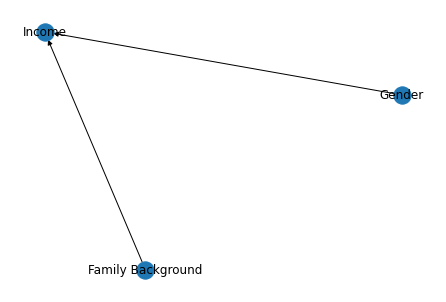

In [39]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Income')
G.add_node('s2', desc='Gender')
G.add_node('s3', desc='Family Background')
G.add_edge('s2','s1')
G.add_edge('s3','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

### 1.3 Monte Carlo Experiments

#### 1.3.1 with covariates not controlled

In [40]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 195.56it/s]


In [41]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.03641830942336827, RMSE=2.1539024162071154, size=0.053
N=1000: bias=0.0328387874769437, RMSE=0.6708720094145548, size=0.042


#### 1.3.2 with covariates controlled

In [42]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:07<00:00, 141.64it/s]


In [43]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.005853121400751198, RMSE=0.1438215573746766, size=0.063
N=1000: bias=-0.0011949301449105914, RMSE=0.04603376846929637, size=0.061


### 1.4 the example of a real-life solution

##### The gender has impact on the income. At the meantime, the family background, the covariate, also influences the income, and having better family background is more likely to have better job. However, the family background will not affect the gender.

## 2、Simulate a DGP with a confounder 

### 2.1 Simulate a DGP

In [11]:
def fn_generate_data_conf(tau,N,p,corr):

    nvar = p+1 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
    X = fn_generate_multnorm(N,corr,nvar)
    C = X[:,1].reshape([N,1]) # confounder
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    Yab = tau*T+0.5*C+err
    Tab = T+0.5*C

    return (Yab,Tab,C)

In [20]:
tau = 5
corr = .4
p = 3
Y,T,C = fn_generate_data_conf(tau,N,p,corr)

In [21]:
data = np.concatenate([Y,T,C],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'C']
data.to_csv('data2.csv')
data

,Y,T,C
0,4.602186,2.276798,2.553596
1,4.199721,2.399209,2.798418
2,-0.287469,0.261446,0.522891
3,5.924566,1.277804,0.555609
4,0.430609,-0.049918,-0.099836
...,...,...,...
995,1.109876,0.799638,1.599276
996,1.670265,0.351319,0.702639
997,-0.449148,-0.968340,-1.936681
998,-0.070348,-0.255025,-0.510051


### 2.2 Illustrate your DGP with a DAG

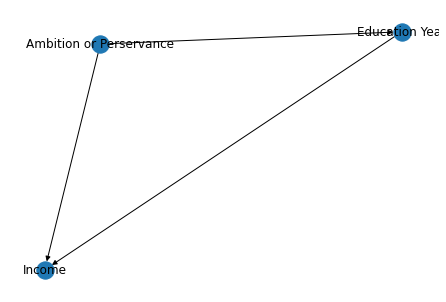

In [23]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Income')
G.add_node('s2', desc='Education Year')
G.add_node('s3', desc='Ambition or Perservance')
G.add_edge('s2','s1')
G.add_edge('s3','s2')
G.add_edge('s3','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

### 2.3 Monte carlo experiments
2.3.1 with a confounder not controlled

In [15]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:12<00:00, 159.48it/s]


In [16]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.3163582681960556, RMSE=0.3509297177521992, size=0.6865
N=1000: bias=-0.32533090757755223, RMSE=0.33877641044258294, size=0.986


#### 2.3.2 with a confounder controlled

In [17]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:06<00:00, 152.85it/s]


In [18]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.007658168368191977, RMSE=0.14112616036700956, size=0.067
N=1000: bias=0.0009465843699023595, RMSE=0.0442584266469135, size=0.047


### 2.4 the example of a real-life solution

##### The education year has impact on the income. The treatment variable is education year. The confounder is ambition or perseverance. The outcome variable is income. In this case, the education will impact income. And people with ambition or perservance will have higher education year which leads to higher income. The people with ambition or perservance will do a better job in work, which will lead to higher income.


## 3 Simulate a DGP with selection bias into the treatment 

### 3.1 Simulate a DGP

In [24]:
def fn_generate_data_s(tau,N,p,corr):

    nvar = p+1 # 1 for selection bias
    corr = 0.5 # correlation for multivariate normal
 
    allX = fn_generate_multnorm(N,corr,nvar)
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    U = np.random.normal(0,1,[N,1])
    Y = tau*T+err
    S = 0.5*T+0.5*Y+U

    return (Y,T,S)

In [25]:
tau = 0.1
corr = 0.5
p = 3
N = 1000
Y,T,S = fn_generate_data_s(tau,N,p,corr)

data = np.concatenate([Y,T,S],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'S']
data.to_csv('data3.csv')
data

,Y,T,S
0,-0.141079,0.0,1.142989
1,0.469998,1.0,1.970725
2,-0.190977,0.0,-0.946997
3,-0.797913,1.0,-0.501756
4,-0.691743,0.0,-1.163443
...,...,...,...
995,-0.899276,0.0,1.225740
996,-0.653876,1.0,-0.060609
997,0.378224,1.0,1.606301
998,-0.472802,0.0,-0.055100


### 3.2 Illustrate your DGP with a DAG

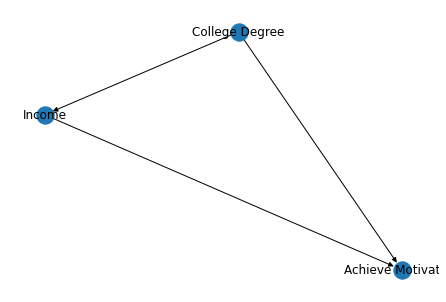

In [31]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Income')
G.add_node('s2', desc='College Degree')
G.add_node('s3', desc='Achieve Motivation')
G.add_edge('s2','s1')
G.add_edge('s1','s3')
G.add_edge('s2','s3')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

### 3.3 Monte carlo experiments

#### 3.3.1 with selection bias not controlled

In [27]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)   
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 194.31it/s]


In [28]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0001811679650731841, RMSE=0.20489967810303528, size=0.067
N=1000: bias=0.00021785340513089224, RMSE=0.06236675931891555, size=0.048


#### 3.3.2 DGP with selection bias controlled

In [29]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)
        covars = np.concatenate([T,Z],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:06<00:00, 145.80it/s]


In [30]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.21347676520166994, RMSE=0.2532354880807739, size=0.367
N=1000: bias=-0.2211969910854141, RMSE=0.22529005049812476, size=0.999


### 3.4 the example of a real-life solution

Comparing wages of individuals with and without a college degree is selection bias.The treatment variable is whether the people have college degree or not. The outcome variable is income. The group with a college degree would be made for the most part of achievers who would have likely done well in their job and received higher wages independently of their education.